# Agregação

Neste processo vamos agregar o dataset de feature com o dataset de pedidos já pré-tratado

### Importação

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from fuzzywuzzy import process
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

plt.style.use('ggplot')

### Carregamento do dataset e separação dos dados do produto

In [69]:
columns_map = {
    'Doc. Date': 'PedidoDataDocumento',
    'Material': 'PedidoProdutoId',
    'Order qty': 'PedidoOrdem',
    'Ship-to nu': 'PedidoAtacadistaId',
    'PCS delivered': 'PedidoQuantidade',
    'HL delivered': 'PedidoHectolitroEntregue',
    'delivery_days': 'PedidoDiasEntrega',
    'delivery_flag': 'PedidoEntregue',
    'lead_time_creation_vs_rdd_flag': 'PedidoLeadTimeEntrega',
    'MACO/HL ': 'PedidoContribuicaoHectolitro',
    'Groupement': 'AtacadistaGrupoImpostoPreco',
    'Postal Code': 'AtacadistaCodigoPostal',
    'Street': 'AtacadistaRuaEndereco',
    'Sous groupement': 'AtacadistaSubgrupo',
    'M2_Territory_ID': 'AtacadistaLocalizacaoId',
    'M1_Territory_ID': 'AtacadistaSubLocalizacaoId',
    'Dépt': 'AtacadistaDepartamento',
    'Brand': 'ProdutoMarca',
    'Subrand': 'ProdutoSubmarca',
    'SEGMENTS : Pils / Spécialités / Superspécialités/Bouteille Young adult': 'ProdutoSegmento2',
    'Container Type': 'ProdutoTipoContainer',
    'Container Size': 'ProdutoTamanhoContainer',
    'Variétés': 'ProdutoVariedade',
    'Segment LE': 'ProdutoSegmento1',
    'Latitude': 'AtacadistaLatitude',
    'Longitude': 'AtacadistaLongitude',
    'Degre Alc': 'ProdutoPercentAlcoolico',
    'TTC': 'PedidoPrecoFinalParaUmProd',
    'Brut + TE': 'PedidoTaxas',
    'DA': 'PedidoTaxaTransporteAereo',
    'Net + TE - Hors majoration de rompu de palette': 'PedidoPrecoLiquidoDescontoPaliteQuebrado'
}

In [70]:
df = pd.read_excel('Data.xlsx')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.columns = df.columns.map(columns_map)

In [71]:
df = df[[column for column in df.columns if 'Produto' in column]]

### Buscando apenas os produtos unicos

In [72]:
print('Quantidade de produtos: ', len(df['PedidoProdutoId']))
print('Quantidade de produtos unicos: ', len(df['PedidoProdutoId'].unique()))

Quantidade de produtos:  73670
Quantidade de produtos unicos:  179


In [73]:
df = df.drop_duplicates(subset=['PedidoProdutoId'])
df.head()

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico
0,10946,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,"6,000 L",Blonde,PREMIUM,6.6
1,19898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
2,80176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,66989,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,"6,000 L",-,SUPER PREMIUM,8.0
4,11766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2


### Ajustando as features

In [74]:
df['ProdutoTamanhoContainer'] = df['ProdutoTamanhoContainer'].apply(lambda x: round(float(str(x).replace('L', '').replace(',', '.').strip()),2))
df['ProdutoTamanhoContainer'] = df['ProdutoTamanhoContainer'].astype(float)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 0 to 71470
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PedidoProdutoId          179 non-null    int64  
 1   ProdutoMarca             74 non-null     object 
 2   ProdutoSubmarca          74 non-null     object 
 3   ProdutoSegmento2         74 non-null     object 
 4   ProdutoTipoContainer     74 non-null     object 
 5   ProdutoTamanhoContainer  74 non-null     float64
 6   ProdutoVariedade         74 non-null     object 
 7   ProdutoSegmento1         74 non-null     object 
 8   ProdutoPercentAlcoolico  133 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 14.0+ KB


In [76]:
columns = [column for column in df.columns if df[column].dtype == object]
columns

['ProdutoMarca',
 'ProdutoSubmarca',
 'ProdutoSegmento2',
 'ProdutoTipoContainer',
 'ProdutoVariedade',
 'ProdutoSegmento1']

In [77]:
for column in columns:
    df[column] = df[column].str.strip()
    df[column] = df[column].fillna('')

In [78]:
columns = [column for column in df.columns if df[column].dtype == float]
for column in columns:
    df[column] = df[column].fillna(0)

In [79]:
df.head()

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico
0,10946,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,6.0,Blonde,PREMIUM,6.6
1,19898,,,,,0.0,,,5.0
2,80176,,,,,0.0,,,0.0
3,66989,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,8.0
4,11766,,,,,0.0,,,5.2


In [80]:
df[df['ProdutoSubmarca'] != '']

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico
0,10946,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,6.00,Blonde,PREMIUM,6.6
3,66989,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,6.00,-,SUPER PREMIUM,8.0
13,70601,GOOSE,GOOSE,Craft,PERFECT DRAFT,6.00,-,SUPER PREMIUM,5.9
14,10947,HOEGAARDEN,HOEGAARDEN WHITE,Spécialités,PERFECT DRAFT,6.00,Blanche,PREMIUM,4.8
15,33335,HOEGAARDEN,HOEGAARDEN ROSEE,Super Spécialités,PERFECT DRAFT,6.00,Rosée,PREMIUM,3.0
...,...,...,...,...,...,...,...,...,...
40977,59940,GINETTE,GINETTE FRUIT,Craft,BOTTLE VP - Hors Tendances,0.33,Fruit,SUPER PREMIUM,0.0
44443,72548,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.33,Bud,PREMIUM LAGER,0.0
45981,75909,GINETTE,GINETTE BLANCHE,Craft,BOTTLE VP - Hors Tendances,0.33,Blanche,SUPER PREMIUM,5.0
47455,77034,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,6.6


### Conversão das variaveis categoricas em numéricas

In [81]:
columns = [column for column in df.columns if df[column].dtype == object]

In [82]:
encoders_produto = {}
df_encoder = pd.DataFrame(df[['PedidoProdutoId', 'ProdutoTamanhoContainer', 'ProdutoPercentAlcoolico']], index=df.index)

for column in columns:
    encoders_produto[column] = LabelEncoder()
    df_encoder[column] = encoders_produto[column].fit_transform(df[column].values.ravel())

df_encoder.head()

,PedidoProdutoId,ProdutoTamanhoContainer,ProdutoPercentAlcoolico,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoVariedade,ProdutoSegmento1
0,10946,6.0,6.6,9,17,4,4,4,1
1,19898,0.0,5.0,0,0,0,0,0,0
2,80176,0.0,0.0,0,0,0,0,0,0
3,66989,6.0,8.0,10,25,2,4,1,3
4,11766,0.0,5.2,0,0,0,0,0,0


In [83]:
scalers_produto = {}
df_escalar = pd.DataFrame(df_encoder['PedidoProdutoId'], index=df_encoder.index)

for column in df_encoder.drop(columns=['PedidoProdutoId']).columns:
    scalers_produto[column] = MinMaxScaler()
    df_escalar[column] = scalers_produto[column].fit_transform(df_encoder[column].values.reshape(-1,1))

df_escalar.head()

,PedidoProdutoId,ProdutoTamanhoContainer,ProdutoPercentAlcoolico,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoVariedade,ProdutoSegmento1
0,10946,1.0,0.733333,0.9,0.68,0.8,1.0,0.235294,0.333333
1,19898,0.0,0.555556,0.0,0.00,0.0,0.0,0.000000,0.000000
2,80176,0.0,0.000000,0.0,0.00,0.0,0.0,0.000000,0.000000
3,66989,1.0,0.888889,1.0,1.00,0.4,1.0,0.058824,1.000000
4,11766,0.0,0.577778,0.0,0.00,0.0,0.0,0.000000,0.000000


### Buscando correlação entre os dados a fim de identificar quais variaveis podem fazer parte do modelo de agrupamento

In [84]:
corr = df_escalar.drop(columns=['PedidoProdutoId']).corr()

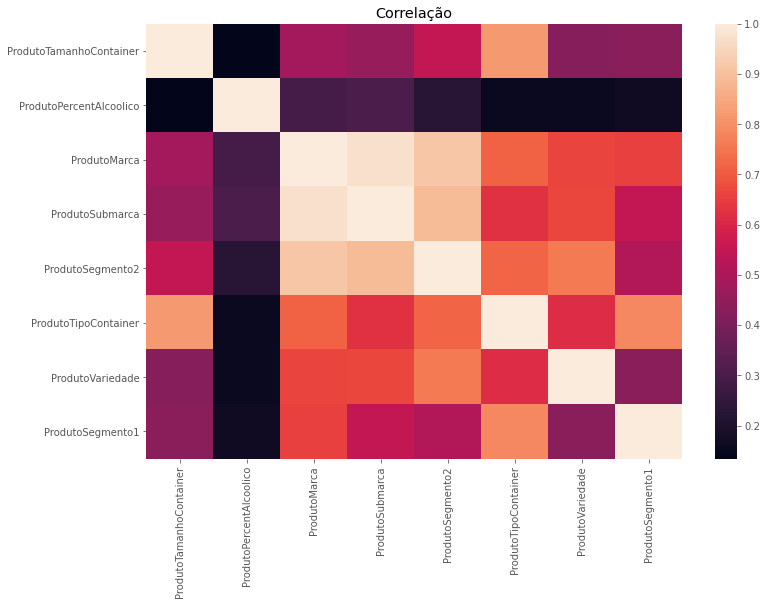

In [85]:
plt.figure(figsize=(12,8))
plt.title('Correlação')
sns.heatmap(corr)
plt.show()

In [86]:
corr

,ProdutoTamanhoContainer,ProdutoPercentAlcoolico,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoVariedade,ProdutoSegmento1
ProdutoTamanhoContainer,1.000000,0.133986,0.488924,0.459483,0.547968,0.818542,0.425738,0.434077
ProdutoPercentAlcoolico,0.133986,1.000000,0.289934,0.305980,0.227638,0.159234,0.157051,0.167855
ProdutoMarca,0.488924,0.289934,1.000000,0.976280,0.915409,0.712991,0.662855,0.654753
ProdutoSubmarca,0.459483,0.305980,0.976280,1.000000,0.888403,0.625998,0.667309,0.548570
ProdutoSegmento2,0.547968,0.227638,0.915409,0.888403,1.000000,0.716612,0.757810,0.514651
ProdutoTipoContainer,0.818542,0.159234,0.712991,0.625998,0.716612,1.000000,0.616439,0.784332
ProdutoVariedade,0.425738,0.157051,0.662855,0.667309,0.757810,0.616439,1.000000,0.432343
ProdutoSegmento1,0.434077,0.167855,0.654753,0.548570,0.514651,0.784332,0.432343,1.000000


Filtrando variáveis com alta correlação para serem removidas do modelo

In [87]:
corr_columns = {}
for a, b in corr[(corr.abs() > 0.75) & (corr.abs() != 1.0)].unstack().dropna().drop_duplicates().index.map(list):
    if a not in corr_columns:
        corr_columns[a] = 1
    else:
        corr_columns[a] = corr_columns[a]+1

    if b not in corr_columns:
        corr_columns[b] = 1
    else:
        corr_columns[b] = corr_columns[b]+1

print(corr_columns)
corr_columns = [key for key, value in corr_columns.items() if value > 1]
print(corr_columns)

{'ProdutoTamanhoContainer': 1, 'ProdutoTipoContainer': 2, 'ProdutoMarca': 2, 'ProdutoSubmarca': 2, 'ProdutoSegmento2': 3, 'ProdutoVariedade': 1, 'ProdutoSegmento1': 1}
['ProdutoTipoContainer', 'ProdutoMarca', 'ProdutoSubmarca', 'ProdutoSegmento2']


Features para segmentação dos produtos em grupos

In [88]:
features = df_escalar.drop(columns=corr_columns + ["PedidoProdutoId"])
features

,ProdutoTamanhoContainer,ProdutoPercentAlcoolico,ProdutoVariedade,ProdutoSegmento1
0,1.0,0.733333,0.235294,0.333333
1,0.0,0.555556,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000
3,1.0,0.888889,0.058824,1.000000
4,0.0,0.577778,0.000000,0.000000
...,...,...,...,...
68396,0.0,0.000000,0.000000,0.000000
68397,0.0,0.000000,0.000000,0.000000
68542,0.0,0.000000,0.000000,0.000000
71226,0.0,0.000000,0.000000,0.000000


### Agrupando registros em clusters

Encontrando a melhor quantidade de grupos de acordo com as variaveis

In [89]:
def quantidade_cluster(data, max_cluster):
    wcss = []
    for n in range(2, max_cluster):
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(X=data)
        wcss.append(kmeans.inertia_)

    return wcss

def quantidade_cluster_otima(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [90]:
wcss = quantidade_cluster(features, 21)
n_cluster = quantidade_cluster_otima(wcss)
print('Numero de clusters sugeridos: {}'.format(n_cluster))

Numero de clusters sugeridos: 7


Reduzindo a dimensionalidade dos dados para exibir graficamente o agrupamento

In [91]:
pca = PCA(n_components=2)
components = pca.fit_transform(features)
print(pca.explained_variance_ratio_)

print('Total de correlação explicada pelos {} componentes principais: {}'.format(pca.n_components, sum(pca.explained_variance_ratio_)))

[0.51112894 0.22681078]
Total de correlação explicada pelos 2 componentes principais: 0.7379397251733995


Agrupando os registros

In [92]:
knn = KMeans(n_clusters=n_cluster)
labels = knn.fit_predict(features)

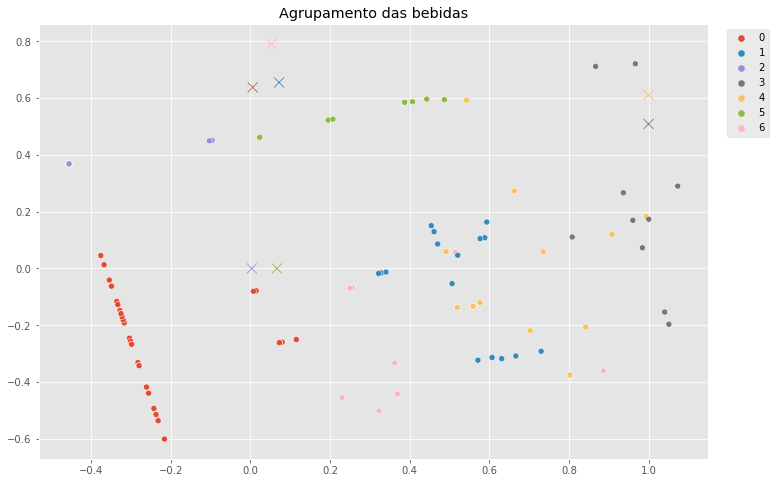

In [93]:
palette = { label: f'C{i}' for i, label in enumerate(range(knn.n_clusters))}

plt.figure(figsize=(12,8))
plt.title('Agrupamento das bebidas')
ax = sns.scatterplot(x=components[:,0], y=components[:,1], hue=knn.labels_, palette=palette)
sns.scatterplot(x=knn.cluster_centers_[:,0], y=knn.cluster_centers_[:,1], hue=range(knn.n_clusters), s=100, palette=palette, legend=False, ax=ax, marker='x')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

In [94]:
print('Silhoutte Score', silhouette_score(features, labels))

Silhoutte Score 0.6473840392487141


In [95]:
df_escalar['cluster'] = labels

In [96]:
df['cluster'] = labels

In [97]:
df[df['cluster'] == 0]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
1,19898,,,,,0.00,,,5.0,0
4,11766,,,,,0.00,,,5.2,0
5,16550,,,,,0.00,,,3.8,0
6,16519,,,,,0.00,,,4.6,0
9,29777,,,,,0.00,,,5.0,0
...,...,...,...,...,...,...,...,...,...,...
33324,72414,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,6.6,0
37134,43113,,,,,0.00,,,5.9,0
38977,67151,,,,,0.00,,,5.9,0
47455,77034,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,6.6,0


In [98]:
df[df['cluster'] == 1]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
21,82315,KWAK,KWAK,Craft,BOTTLE VP - Hors Tendances,0.75,-,SUPER PREMIUM,8.4,1
22,59874,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VC,0.33,-,SUPER PREMIUM,8.4,1
33,63466,GOOSE,GOOSE,Craft,BOTTLE VP - Hors Tendances,0.35,-,SUPER PREMIUM,4.2,1
66,77311,CORONA,CORONA EXTRA,Bouteille Young Adult,BOTTLE VP - Tendances,0.35,Corona,SUPER PREMIUM,4.5,1
108,77589,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.33,Bud,PREMIUM LAGER,5.0,1
111,59873,KWAK,KWAK,Craft,BOTTLE VC,0.33,-,SUPER PREMIUM,8.4,1
236,63445,GOOSE,GOOSE,Craft,BOTTLE VP - Hors Tendances,0.35,-,SUPER PREMIUM,5.9,1
390,79923,CAMDEN,CAMDEN PALE ALE,Craft,BOTTLE VP - Hors Tendances,0.33,-,SUPER PREMIUM,4.0,1
394,79894,CAMDEN,CAMDEN HELLS,Craft,BOTTLE VP - Hors Tendances,0.33,-,SUPER PREMIUM,4.6,1
500,70225,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VP - Hors Tendances,0.75,Blonde,SUPER PREMIUM,8.4,1


In [99]:
df[df['cluster'] == 2]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
2,80176,,,,,0.00,,,0.0,2
720,69490,LEFFE,"LEFFE BLONDE 0,0",Spécialités,BOTTLE VC,0.33,Blonde,PREMIUM,0.0,2
1119,71275,,,,,0.00,,,0.0,2
1146,57005,,,,,0.00,,,0.0,2
1266,77978,,,,,0.00,,,0.0,2
1268,77721,LEFFE,"LEFFE BLONDE 0,0",Spécialités,BOTTLE VC,0.33,Blonde,PREMIUM,0.0,2
1269,15793,,,,,0.00,,,0.0,2
1408,58941,,,,,0.00,,,0.0,2
2096,48538,,,,,0.00,,,0.0,2
2098,46093,,,,,0.00,,,0.0,2


In [100]:
df[df['cluster'] == 3]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
3,66989,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,8.0,3
13,70601,GOOSE,GOOSE,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,5.9,3
23,71316,BUD,BUD,Pils,PERFECT DRAFT,6.0,Bud,PREMIUM LAGER,5.0,3
29,61629,KWAK,KWAK,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,8.4,3
224,70605,BIRRA DEL BORGO,BIRRA DEL BORGO,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,5.0,3
384,81408,GINETTE,GINETTE BLANCHE,Craft,PERFECT DRAFT,6.0,Blanche,SUPER PREMIUM,5.0,3
1032,81410,GINETTE,GINETTE FRUIT,Craft,PERFECT DRAFT,6.0,Fruit,SUPER PREMIUM,4.0,3
1575,81409,GINETTE,GINETTE BLANCHE,Craft,PERFECT DRAFT,6.0,Blanche,SUPER PREMIUM,0.0,3
1577,81411,GINETTE,GINETTE FRUIT,Craft,PERFECT DRAFT,6.0,Fruit,SUPER PREMIUM,0.0,3
2102,68280,GOOSE,GOOSE,Craft,PERFECT DRAFT,6.0,-,SUPER PREMIUM,4.1,3


In [101]:
df[df['cluster'] == 4]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
0,10946,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,6.0,Blonde,PREMIUM,6.6,4
14,10947,HOEGAARDEN,HOEGAARDEN WHITE,Spécialités,PERFECT DRAFT,6.0,Blanche,PREMIUM,4.8,4
15,33335,HOEGAARDEN,HOEGAARDEN ROSEE,Super Spécialités,PERFECT DRAFT,6.0,Rosée,PREMIUM,3.0,4
18,20614,LEFFE,LEFFE RUBY,Super Spécialités,PERFECT DRAFT,6.0,Ruby,PREMIUM,5.0,4
30,64665,LEFFE,LEFFE AMBREE,Spécialités,PERFECT DRAFT,6.0,Ambrée,PREMIUM,6.6,4
31,17028,LEFFE,LEFFE RITUEL 9°,Super Spécialités,PERFECT DRAFT,6.0,Rituel,PREMIUM,9.0,4
39,53566,LEFFE,LEFFE ROYALE,Super Spécialités,PERFECT DRAFT,6.0,IPA,PREMIUM,7.5,4
48,48537,LEFFE,LEFFE ROYALE,Super Spécialités,PERFECT DRAFT,6.0,Whitbread Golding,PREMIUM,7.5,4
123,74342,GINETTE,GINETTE LAGER,Craft,PERFECT DRAFT,6.0,Triple,PREMIUM LAGER,4.5,4
130,10611,LEFFE,LEFFE BRUNE,Spécialités,PERFECT DRAFT,6.0,Brune,PREMIUM,6.5,4


In [102]:
df[df['cluster'] == 5]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
76,47934,LEFFE,LEFFE ROYALE,Super Spécialités,BOTTLE VC,0.33,IPA,PREMIUM,0.0,5
13558,59939,GINETTE,GINETTE BLONDE,Craft,BOTTLE VP - Hors Tendances,0.33,Blonde,SUPER PREMIUM,0.0,5
27927,59895,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VP - Hors Tendances,0.75,Blonde,SUPER PREMIUM,0.0,5
37103,18827,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.33,Bud,PREMIUM LAGER,0.0,5
37581,59941,GINETTE,GINETTE BLANCHE,Craft,BOTTLE VP - Hors Tendances,0.33,Blanche,SUPER PREMIUM,0.0,5
40977,59940,GINETTE,GINETTE FRUIT,Craft,BOTTLE VP - Hors Tendances,0.33,Fruit,SUPER PREMIUM,0.0,5
44443,72548,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.33,Bud,PREMIUM LAGER,0.0,5
53856,69407,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.47,Bud,PREMIUM LAGER,0.0,5


In [103]:
df[df['cluster'] == 6]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster
84,30822,LEFFE,LEFFE RUBY,Super Spécialités,BOTTLE VC,0.33,Ruby,PREMIUM,5.0,6
266,10958,HOEGAARDEN,HOEGAARDEN GRAND CRU,Spécialités,BOTTLE VC,0.33,Grand Cru,PREMIUM,8.5,6
618,59942,GINETTE,GINETTE TRIPLE,Craft,BOTTLE VP - Hors Tendances,0.33,Triple,SUPER PREMIUM,9.0,6
4778,74529,GINETTE,GINETTE LAGER,Craft,BOTTLE VP - Hors Tendances,0.33,Triple,PREMIUM LAGER,4.5,6
5143,3507,LEFFE,LEFFE RITUEL 9°,Super Spécialités,BOTTLE VC,0.33,Rituel,PREMIUM,9.0,6
10740,62474,LEFFE,LEFFE RUBY,Super Spécialités,BOTTLE VP - Hors Tendances,0.25,Ruby,PREMIUM,5.0,6
12756,40093,LEFFE,LEFFE ROYALE,Super Spécialités,BOTTLE VC,0.33,Whitbread Golding,PREMIUM,7.5,6
15320,9937,LEFFE,LEFFE TRIPLE,Spécialités,BOTTLE VC,0.33,Triple,PREMIUM,8.5,6


In [104]:
df_feature = df_escalar.drop(columns=corr_columns).copy()
df_feature['submarca'] = df['ProdutoSubmarca']

## Enriquecimento com dataset de caracteristica

In [105]:
df_caracteristica = pd.read_csv('produto_caracteristica_feature.csv')
df_caracteristica.drop(columns=['Unnamed: 0'], inplace=True)
df_caracteristica.rename({'Unnamed: 2': ' '}, inplace=True, axis=1)
df_caracteristica.head()

,submarca,ale,alto,amargor,amendoim,ano,aromar,açúcar,açúcar lúpulo,brahma,...,sabor,salada,suave,tradicional,trazer,trigar,ºc,água,água maltar,único
0,ADRIATICA,0.0,0.284281,0.00000,0.0,0.0,0.170864,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.098314,0.0,0.000000
1,ANDES,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.130417,0.0,0.000000
2,BECKS,0.0,0.196094,0.28816,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.204332,0.162957,0.000000,0.210029,0.0,0.0,0.121535,0.067816,0.0,0.210029
3,BERRIO DO PIAUI,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.175158,0.000000,0.000000,0.000000,0.0,0.0,0.208365,0.116267,0.0,0.000000
4,BUDWEISER,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.260695,0.000000,0.446753,0.000000,0.0,0.0,0.155059,0.086523,0.0,0.267964


Relacionando dados da tabela principal com os dados de caracteristica

In [106]:
submarca_produto = df_feature['submarca'].unique()
print(len(submarca_produto), submarca_produto[0:10])
submarca_caracteristica = df_caracteristica['submarca'].unique()
print(len(submarca_caracteristica), submarca_caracteristica[0:10])

26 ['LEFFE BLONDE' '' 'TRIPLE KARMELIET' 'GOOSE' 'HOEGAARDEN WHITE'
 'HOEGAARDEN ROSEE' 'LEFFE RUBY' 'KWAK' 'BUD' 'LEFFE AMBREE']
84 ['ADRIATICA' 'ANDES' 'BECKS' 'BERRIO DO PIAUI' 'BUDWEISER' 'CARACU'
 'ESMERA DE GOIAS' 'HOEGAARDEN' 'LEFFE' 'LEGITIMA']


In [107]:
ratio = 85
dict_map = {}

for prod in submarca_produto:
    (carac, value), *_ = process.extract(prod, submarca_caracteristica)
    
    if value > ratio:
        dict_map[prod] = carac

print(len(dict_map))
print(dict_map)

17
{'LEFFE BLONDE': 'LEFFE', 'GOOSE': 'GOOSE ISLANDGOOSE IPA', 'HOEGAARDEN WHITE': 'HOEGAARDEN', 'HOEGAARDEN ROSEE': 'HOEGAARDEN', 'LEFFE RUBY': 'LEFFE', 'BUD': 'BUDWEISER', 'LEFFE AMBREE': 'LEFFE', 'LEFFE RITUEL 9°': 'LEFFE', 'LEFFE ROYALE': 'LEFFE', 'CORONA EXTRA': 'CORONA', 'GINETTE LAGER': 'BRAHMA EXTRA RED LAGER', 'LEFFE BRUNE': 'LEFFE', 'LEFFE LA LEGERE': 'LEFFE', 'HOEGAARDEN GRAND CRU': 'HOEGAARDEN', 'CAMDEN PALE ALE': 'GOOSE ISLAND HONKERS ALE', 'LEFFE BLONDE 0,0': 'LEFFE', 'LEFFE TRIPLE': 'LEFFE'}


In [108]:
not_key = [key for key in submarca_produto if key not in dict_map.keys()]
print(not_key)
print()
not_carac = [carac for carac in submarca_caracteristica if carac not in dict_map.values()]
print(not_carac)

['', 'TRIPLE KARMELIET', 'KWAK', 'BIRRA DEL BORGO', 'GINETTE BLANCHE', 'CAMDEN HELLS', 'GINETTE TRIPLE', 'GINETTE FRUIT', 'GINETTE BLONDE']

['ADRIATICA', 'ANDES', 'BECKS', 'BERRIO DO PIAUI', 'CARACU', 'ESMERA DE GOIAS', 'LEGITIMA', 'MAGNIFICA DO MARANHAO', 'MICHELOB ULTRA', 'MODELO', 'NOSSA', 'ORIGINAL', 'POLAR', 'SERRAMALTE', 'SERRANA', 'SPATEN', 'TRES FIDALGAS', 'ANTARCTICA CRISTAL', 'ANTARCTICA PILSEN', 'ANTARCTICA SUBZERO', 'BOHEMIA 14 WEISS', 'BOHEMIA 838 PALE ALE', 'BOHEMIA AURA LAGER', 'BOHEMIA MAGNA PILS', 'BOHEMIA PURO MALTE', 'BRAHMA CHOPP PILSEN', 'BRAHMA DUPLO MALTE', 'BRAHMA EXTRA LAGER', 'BRAHMA EXTRA WEISS', 'BRAHMA MALZIBIER', 'BRAHMA REFRESH', 'BRAHMA ZERO', 'CERVEJARIA COLORADOCOLORADO APPIA', 'CERVEJARIA COLORADOCOLORADO BERTHO', 'CERVEJARIA COLORADOCOLORADO CAUIM', 'CERVEJARIA COLORADOCOLORADO CAUIM 016', 'CERVEJARIA COLORADOCOLORADO DEMOISELLE', 'CERVEJARIA COLORADOCOLORADO EUGENIA', 'CERVEJARIA COLORADOCOLORADO GUANABARA', 'CERVEJARIA COLORADOCOLORADO INDICA', 'C

Incluindo dados mocados no dataset a fim de ter mais informações sobre os produtos x caracteristicas mapeadas

In [109]:
for i, key in enumerate(not_key):
    dict_map[key] = not_carac[i]

In [110]:
caract_prod = {value: key for key, value in dict_map.items()}

In [111]:
df_prod_ajustado = pd.read_csv('produto_caracteristica_ajustado.csv')
df_prod_ajustado.drop(columns=['Unnamed: 0'], inplace=True)
df_prod_ajustado['de_para'] = df_prod_ajustado['submarca'].apply(lambda x: caract_prod.get(x, ''))

In [112]:
df_prod_ajustado.to_csv('produto_caracteristica_ajustado.csv', header=True)

In [113]:
df['de_para'] = df_feature['submarca'].apply(lambda x: dict_map.get(x, ''))
df_feature['de_para'] = df_feature['submarca'].apply(lambda x: dict_map.get(x, ''))

In [114]:
df_model = pd.merge(df_feature, df_caracteristica, how='inner', left_on='de_para', right_on='submarca')
df_model.fillna(0.0, inplace=True)
df_model.drop(columns=['submarca_x', 'submarca_y', 'de_para'], inplace=True)


In [115]:
df_model

,PedidoProdutoId,ProdutoTamanhoContainer,ProdutoPercentAlcoolico,ProdutoVariedade,ProdutoSegmento1,cluster,ale,alto,amargor,amendoim,...,sabor,salada,suave,tradicional,trazer,trigar,ºc,água,água maltar,único
0,10946,1.000,0.733333,0.235294,0.333333,4,0.252081,0.000000,0.0,0.0,...,0.143310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095127,0.0,0.0
1,20614,1.000,0.555556,0.882353,0.333333,4,0.252081,0.000000,0.0,0.0,...,0.143310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095127,0.0,0.0
2,64665,1.000,0.733333,0.117647,0.333333,4,0.252081,0.000000,0.0,0.0,...,0.143310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095127,0.0,0.0
3,17028,1.000,1.000000,0.764706,0.333333,4,0.252081,0.000000,0.0,0.0,...,0.143310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095127,0.0,0.0
4,53566,1.000,0.833333,0.588235,0.333333,4,0.252081,0.000000,0.0,0.0,...,0.143310,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.095127,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,81410,1.000,0.444444,0.470588,1.000000,3,0.000000,0.186864,0.0,0.0,...,0.194714,0.155286,0.0,0.0,0.200143,0.0,0.115814,0.064624,0.0,0.0
175,81411,1.000,0.000000,0.470588,1.000000,3,0.000000,0.186864,0.0,0.0,...,0.194714,0.155286,0.0,0.0,0.200143,0.0,0.115814,0.064624,0.0,0.0
176,76952,0.055,0.444444,0.470588,1.000000,1,0.000000,0.186864,0.0,0.0,...,0.194714,0.155286,0.0,0.0,0.200143,0.0,0.115814,0.064624,0.0,0.0
177,59940,0.055,0.000000,0.470588,1.000000,5,0.000000,0.186864,0.0,0.0,...,0.194714,0.155286,0.0,0.0,0.200143,0.0,0.115814,0.064624,0.0,0.0


## Agrupando com os dados de caracteristicas

In [116]:
feature_caracteristica = df_model.drop(columns = ['PedidoProdutoId', 'cluster'])

In [117]:
wcss = quantidade_cluster(feature_caracteristica,  21)
n_clusters = quantidade_cluster_otima(wcss)
print(n_clusters)

8


In [118]:
knn_caracteristica = KMeans(n_clusters)
labels = knn_caracteristica.fit_predict(feature_caracteristica)

In [119]:
pca_caracteristica = PCA(n_components=2)
components_caracteristica = pca_caracteristica.fit_transform(feature_caracteristica)

In [120]:
print(pca_caracteristica.explained_variance_ratio_)

print('Total de correlação explicada pelos {} componentes principais: {}'.format(pca_caracteristica.n_components, sum(pca_caracteristica.explained_variance_ratio_)))

[0.4481291  0.12838864]
Total de correlação explicada pelos 2 componentes principais: 0.5765177370384071


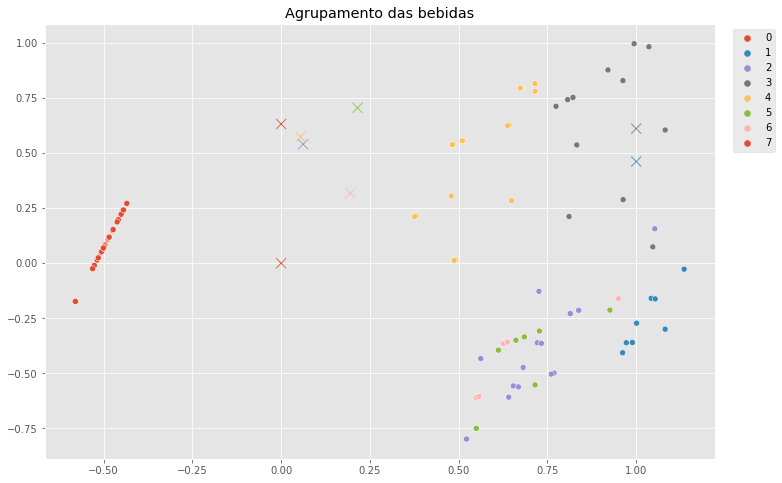

In [121]:
palette = { label: f'C{i}' for i, label in enumerate(range(knn_caracteristica.n_clusters))}

plt.figure(figsize=(12,8))
plt.title('Agrupamento das bebidas')
ax = sns.scatterplot(x=components_caracteristica[:,0], y=components_caracteristica[:,1], hue=knn_caracteristica.labels_, palette=palette)
sns.scatterplot(x=knn_caracteristica.cluster_centers_[:,0], y=knn_caracteristica.cluster_centers_[:,1], hue=range(knn_caracteristica.n_clusters), s=100, palette=palette, legend=False, ax=ax, marker='x')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

In [122]:
print('Silhoutte Score', silhouette_score(components_caracteristica, labels))

Silhoutte Score 0.5453530114789222


In [123]:
df_model['cluster_caracteristica'] = labels
df['cluster_caracteristica'] = labels

In [124]:
df[df['cluster_caracteristica'] == 0]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
33,63466,GOOSE,GOOSE,Craft,BOTTLE VP - Hors Tendances,0.35,-,SUPER PREMIUM,4.2,1,GOOSE ISLANDGOOSE IPA,0
48,48537,LEFFE,LEFFE ROYALE,Super Spécialités,PERFECT DRAFT,6.00,Whitbread Golding,PREMIUM,7.5,4,LEFFE,0
51,60036,,,,,0.00,,,5.2,0,ADRIATICA,0
57,67561,,,,,0.00,,,5.0,0,ADRIATICA,0
65,80125,,,,,0.00,,,5.0,0,ADRIATICA,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2495,76952,GINETTE,GINETTE FRUIT,Craft,BOTTLE VP - Hors Tendances,0.33,Fruit,SUPER PREMIUM,4.0,1,MAGNIFICA DO MARANHAO,0
3255,61685,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VP - Hors Tendances,0.33,Blonde,SUPER PREMIUM,8.4,1,ANDES,0
3473,76828,GINETTE,GINETTE BLANCHE,Craft,BOTTLE VP - Hors Tendances,0.33,Blanche,SUPER PREMIUM,5.0,1,CARACU,0
4203,20527,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.33,Blonde,PREMIUM,6.6,0,LEFFE,0


In [125]:
df[df['cluster_caracteristica'] == 1]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
21614,15800,,,,,0.00,,,0.0,2,ADRIATICA,1
21886,58245,,,,,0.00,,,0.0,2,ADRIATICA,1
25725,72413,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,6.6,0,LEFFE,1
39640,21416,,,,,0.00,,,0.0,2,ADRIATICA,1
40977,59940,GINETTE,GINETTE FRUIT,Craft,BOTTLE VP - Hors Tendances,0.33,Fruit,SUPER PREMIUM,0.0,5,MAGNIFICA DO MARANHAO,1
40978,15740,,,,,0.00,,,0.0,2,ADRIATICA,1
43007,65716,,,,,0.00,,,0.0,2,ADRIATICA,1
68396,3643,,,,,0.00,,,0.0,2,ADRIATICA,1
68397,15757,,,,,0.00,,,0.0,2,ADRIATICA,1


In [126]:
df[df['cluster_caracteristica'] == 2]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
21762,62706,,,,,0.00,,,6.6,0,ADRIATICA,2
21763,62707,,,,,0.00,,,6.6,0,ADRIATICA,2
25090,58277,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,0.0,2,LEFFE,2
25924,10687,,,,,0.00,,,0.0,2,ADRIATICA,2
25969,78123,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.47,Bud,PREMIUM LAGER,5.0,1,BUDWEISER,2
25980,63479,,,,,0.00,,,0.0,2,ADRIATICA,2
37134,43113,,,,,0.00,,,5.9,0,ADRIATICA,2
37233,45918,,,,,0.00,,,0.0,2,ADRIATICA,2
37581,59941,GINETTE,GINETTE BLANCHE,Craft,BOTTLE VP - Hors Tendances,0.33,Blanche,SUPER PREMIUM,0.0,5,CARACU,2
37944,62033,,,,,0.00,,,0.0,2,ADRIATICA,2


In [127]:
df[df['cluster_caracteristica'] == 3]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
0,10946,LEFFE,LEFFE BLONDE,Spécialités,PERFECT DRAFT,6.00,Blonde,PREMIUM,6.6,4,LEFFE,3
1,19898,,,,,0.00,,,5.0,0,ADRIATICA,3
2,80176,,,,,0.00,,,0.0,2,ADRIATICA,3
3,66989,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,PERFECT DRAFT,6.00,-,SUPER PREMIUM,8.0,3,ANDES,3
4,11766,,,,,0.00,,,5.2,0,ADRIATICA,3
5,16550,,,,,0.00,,,3.8,0,ADRIATICA,3
11,3450,,,,,0.00,,,4.8,0,ADRIATICA,3
12,63480,,,,,0.00,,,5.0,0,ADRIATICA,3
22,59874,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VC,0.33,-,SUPER PREMIUM,8.4,1,ANDES,3
22460,67562,,,,,0.00,,,5.0,0,ADRIATICA,3


In [128]:
df[df['cluster_caracteristica'] == 4]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
6,16519,,,,,0.00,,,4.6,0,ADRIATICA,4
9,29777,,,,,0.00,,,5.0,0,ADRIATICA,4
10,48859,,,,,0.00,,,5.2,0,ADRIATICA,4
13,70601,GOOSE,GOOSE,Craft,PERFECT DRAFT,6.00,-,SUPER PREMIUM,5.9,3,GOOSE ISLANDGOOSE IPA,4
14,10947,HOEGAARDEN,HOEGAARDEN WHITE,Spécialités,PERFECT DRAFT,6.00,Blanche,PREMIUM,4.8,4,HOEGAARDEN,4
15,33335,HOEGAARDEN,HOEGAARDEN ROSEE,Super Spécialités,PERFECT DRAFT,6.00,Rosée,PREMIUM,3.0,4,HOEGAARDEN,4
18,20614,LEFFE,LEFFE RUBY,Super Spécialités,PERFECT DRAFT,6.00,Ruby,PREMIUM,5.0,4,LEFFE,4
19,63481,,,,,0.00,,,5.2,0,ADRIATICA,4
21,82315,KWAK,KWAK,Craft,BOTTLE VP - Hors Tendances,0.75,-,SUPER PREMIUM,8.4,1,BECKS,4
23,71316,BUD,BUD,Pils,PERFECT DRAFT,6.00,Bud,PREMIUM LAGER,5.0,3,BUDWEISER,4


In [129]:
df[df['cluster_caracteristica'] == 5]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
13558,59939,GINETTE,GINETTE BLONDE,Craft,BOTTLE VP - Hors Tendances,0.33,Blonde,SUPER PREMIUM,0.0,5,MICHELOB ULTRA,5
15320,9937,LEFFE,LEFFE TRIPLE,Spécialités,BOTTLE VC,0.33,Triple,PREMIUM,8.5,6,LEFFE,5
20068,66719,BIRRA DEL BORGO,BIRRA DEL BORGO,Craft,PERFECT DRAFT,6.00,-,SUPER PREMIUM,5.0,3,BERRIO DO PIAUI,5
20069,73181,,,,,0.00,,,0.0,2,ADRIATICA,5
20198,18692,,,,,0.00,,,4.9,0,ADRIATICA,5
20277,6108,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.75,Blonde,PREMIUM,6.6,0,LEFFE,5
53851,76626,,,,,0.00,,,0.0,2,ADRIATICA,5
53856,69407,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.47,Bud,PREMIUM LAGER,0.0,5,BUDWEISER,5


In [130]:
df[df['cluster_caracteristica'] == 6]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
25988,58328,,,,,0.00,,,0.0,2,ADRIATICA,6
26863,53425,,,,,0.00,,,4.9,0,ADRIATICA,6
27927,59895,TRIPLE KARMELIET,TRIPLE KARMELIET,Craft,BOTTLE VP - Hors Tendances,0.75,Blonde,SUPER PREMIUM,0.0,5,ANDES,6
29051,61684,KWAK,KWAK,Craft,BOTTLE VP - Hors Tendances,0.33,-,SUPER PREMIUM,8.4,1,BECKS,6
30194,64590,CAMDEN,CAMDEN HELLS,Craft,BOTTLE VP - Hors Tendances,0.33,-,SUPER PREMIUM,4.6,1,ESMERA DE GOIAS,6
33324,72414,LEFFE,LEFFE BLONDE,Spécialités,BOTTLE VP - Hors Tendances,0.25,Blonde,PREMIUM,6.6,0,LEFFE,6
37103,18827,BUD,BUD,Bouteille Young Adult,BOTTLE VP - Tendances,0.33,Bud,PREMIUM LAGER,0.0,5,BUDWEISER,6


In [131]:
df[df['cluster_caracteristica'] == 7]

,PedidoProdutoId,ProdutoMarca,ProdutoSubmarca,ProdutoSegmento2,ProdutoTipoContainer,ProdutoTamanhoContainer,ProdutoVariedade,ProdutoSegmento1,ProdutoPercentAlcoolico,cluster,de_para,cluster_caracteristica
39,53566,LEFFE,LEFFE ROYALE,Super Spécialités,PERFECT DRAFT,6.00,IPA,PREMIUM,7.5,4,LEFFE,7
1052,63311,,,,,0.00,,,4.5,0,ADRIATICA,7
1079,15985,,,,,0.00,,,5.0,0,ADRIATICA,7
1102,62770,,,,,0.00,,,3.3,0,ADRIATICA,7
1119,71275,,,,,0.00,,,0.0,2,ADRIATICA,7
1133,66839,,,,,0.00,,,7.5,0,ADRIATICA,7
1147,63627,,,,,0.00,,,5.9,0,ADRIATICA,7
1183,74583,,,,,0.00,,,4.0,0,ADRIATICA,7
1216,67049,,,,,0.00,,,5.9,0,ADRIATICA,7
1266,77978,,,,,0.00,,,0.0,2,ADRIATICA,7


In [132]:
df_model.to_csv('produto_model.csv', header=True)
df.to_csv('produto_data.csv', header=True)

### Visualização do dado mocado

In [133]:
df[['ProdutoSubmarca', 'de_para']].head(20)

,ProdutoSubmarca,de_para
0,LEFFE BLONDE,LEFFE
1,,ADRIATICA
2,,ADRIATICA
3,TRIPLE KARMELIET,ANDES
4,,ADRIATICA
5,,ADRIATICA
6,,ADRIATICA
9,,ADRIATICA
10,,ADRIATICA
11,,ADRIATICA


## Persistencia de objetos utilizados no fluxo

In [134]:
import pickle

pickle.dump(encoders_produto, open('encoders_produto.pickle', 'wb'))
pickle.dump(scalers_produto, open('scalers_produto.pickle', 'wb'))
pickle.dump(pca_caracteristica, open('pca_caracteristica.pickle', 'wb'))
pickle.dump(knn_caracteristica, open('knn_caracteristica.pickle', 'wb'))
pickle.dump(dict_map, open('dict_map.pickle', 'wb'))
